In [606]:
import os
import cv2
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from PIL import Image
import random

In [607]:
class NeuralNetwork :
    # init the nerual network
    def initialize_parameters(self,layerdims):
        parameters={}
        L = len(layerdims)
        for i in range(1, L):
            #parameters["w"+str(i)] = np.random.randn( layerdims[i], layerdims[i-1]) * 0.1
            # normal distribution 
            parameters["w"+str(i)] = np.random.normal(0.0, pow(layerdims[i-1], -0.5), ( layerdims[i], layerdims[i-1]))

            #parameters["b"+str(i)] = np.zeros( (layerdims[i],1))

        return parameters



In [608]:
NeuralNetwork = NeuralNetwork()


In [609]:


def feedforward(Input,Weights,activation):
    
    #Z = np.add( np.dot(Weights,prev), bias)
    Z = np.dot(Weights,Input)
    
     #Activation Function 
    if activation== "sigmoid":
        A=1/(1+np.exp(-Z))
        
    layerParam =(Input,Weights,Z)
    return A,layerParam

def LayersForward(_input,_size,_params):
    #print("input shape: {}".format(_input.shape))
    prev = _input
    layerParams = []
    for i in range(1,len(_size)):
        prev,layerParam = feedforward(prev,_params["w"+str(i)],"sigmoid")
        layerParams.append(layerParam)
        
    return prev,layerParams

def calculateCost(predict,target,function="Quadratic"):
    
    if function== "Quadratic":
        #cost = .5 * np.sum((target-predict)**2)
        
        # cost function = 1/2n |target-predict|^2 
        # for single training set
        cost = .5 * np.sum( (np.abs(target-predict))**2 )
        return cost


def feedbackward(dError,layerParam,activation="sigmoid"):
    
    prev,Weights,Z = layerParam
    
    if activation == "sigmoid":
        s = 1/(1+np.exp(-Z))
        dZ = dError * s * (1-s)
        
    # Computing derivative of Cost wrt A & W  & b
    dError_prev = np.dot(Weights.transpose(), dZ)
    #print(dError_prev.shape)
    dW = 1/len(trainX) * np.dot(dZ, dError_prev.transpose())
    #print(dW.shape)

    #db =  np.sum(dZ, axis=1, keepdims=True)
   
    
    return dError_prev, dW

def layersBackward(predicted, target , layerParams, networkSize):
    
    currentOutput = predicted
    L = len(networkSize) -1
    grads={}
    

    # derivation of Cost wrt current Output
    deriv_error = 2 * (currentOutput - target)
    
    #print("deriv_error shape: {}".format(deriv_error.flatten().shape))
    grads["dA"+str(L)], grads["dW"+str(L)] = feedbackward(deriv_error, layerParams[-1], "sigmoid")
    
    for i in list(reversed(range(L-1))):      
        #print("backdrop in layer {}".format(i))
        current_Layerparams = layerParams[i]
        a,b = feedbackward(grads["dA"+str(i+2)], current_Layerparams, activation="sigmoid")
        grads["dA"+str(i+1)] = a
        #print(grads["dA"+str(i+1)])
        grads["dW"+str(i+1)] = b
        #grads["db"+str(i+1)] = c
        
    return grads

def update_params(params, grads, learning_rate):
    # each layer has 2 parameters (W,b)
    L = len(params) // 2
    for l in range(L):
        params["w"+str(l+1)] = params["w"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        #params["b"+str(l+1)] = params["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]
        
    return params

In [610]:
cwd=os.getcwd()
data_path_training = cwd + '/training'
data_path_testing = cwd + '/testing'

directories = [d for d in os.listdir(data_path_training) 
                   if os.path.isdir(os.path.join(data_path_training, d))]
test_images = []
test_labels = []
labels = []
images = []
for image in os.listdir(data_path_testing):
    test_labels.append(image.split("_")[0])
    url = os.path.join(data_path_testing,image)
    img = np.array(Image.open(url))
    test_images.append(img)
for d in directories:
    label_dir = os.path.join(data_path_training, d)
    filenames = [os.path.join(label_dir, file) for file in os.listdir(label_dir) if file.endswith(('.png','.jpg')) ]
    
    for f in filenames:
        img = np.array(Image.open(f))
        images.append(img)
        labels.append(d)

print("Unique Classes: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))
test_percentage = len(test_images) / (len(images) + len(test_images)) 
print("Test images: {} ({}%)".format(len(test_images),int(test_percentage*100)))


Unique Classes: 21
Total Images: 383
Test images: 193 (33%)


In [611]:
trainX = []
trainY = []
for record in images:
        # scale and shift the inputs
        Input = ((np.asfarray(record) / 255.0 * 0.99) + 0.01 ).flatten()
        Input = np.array(Input, ndmin=2).T
        trainX.append(Input)
for label in labels:
        trainY.append(label)

In [615]:
def trainModel(trainX,trainY,iterations,Params,learningRate):
    costs=[]  
    # Gradient Descent
    print("in progress..... \n")
    for i in range(iterations):
        label_index = 0
        progress = "=="
        for record in trainX:            
            # create the target output values (all 0.01, except the desired label which is 0.99)
            targets = np.zeros(output_nodes) + 0.01
            # the target label for this record
            target_class = trainY[label_index]    
            # feedforward propagation
            pred_output, layerHistory = LayersForward(record, layerSize,Params)
            # scale and shift the desired outputs 
            targets[int(target_class)] = 0.99
            # convert targets array to fit 2-dims as inputs array
            targets = np.array(targets, ndmin=2).T
            # Compute Cost  
            cost = calculateCost(pred_output, targets)

            # Backward propagation
            grads = layersBackward(pred_output, targets, layerHistory, layerSize)

            # Update Parameters
            Params = update_params(Params, grads, learningRate)
            label_index +=1
        progress = progress + "=="
        # + "{}%".format((i/epochs)*100)
        print(progress,end="", flush=True)    
        if i%200 == 0:
            print(f"cost {i}: {np.squeeze(cost)}")
        if i%100 ==0:
            costs.append(cost)

    
    return parameters,costs


In [617]:
input_nodes = 6720
hidden1_nodes = 300
#hidden2_nodes = 25
output_nodes = 22

epochs = 2000
learning_rate = .005

layerSize = [input_nodes,hidden1_nodes,output_nodes]

_params = NeuralNetwork.initialize_parameters(layerSize)


In [ ]:
params,costs = trainModel(trainX,trainY,epochs,_params,learning_rate)

In [620]:
print(_params)

{'w1': array([[ 2.55141886e-03, -7.87950083e-05, -6.40655996e-03, ...,
         1.85785482e-02, -8.72739677e-04,  1.37840423e-02],
       [-5.82781858e-03, -1.55613282e-02,  1.21875721e-03, ...,
         7.12524592e-04, -1.69519687e-02, -1.44990992e-03],
       [-1.28570721e-02, -1.77369827e-02, -1.40797103e-02, ...,
         4.35023651e-03,  8.13778728e-03,  1.28723121e-03],
       ...,
       [ 2.63724924e-02,  5.33093870e-03,  3.58681868e-04, ...,
        -1.28630176e-03, -1.25017775e-02,  1.15032441e-02],
       [-1.61071931e-02, -3.18199096e-03,  1.70274871e-03, ...,
        -3.47196334e-05, -1.57078152e-03, -9.19750924e-03],
       [-2.42271801e-02,  4.17678084e-03, -1.20706667e-02, ...,
        -2.25607115e-02, -8.02588787e-03, -4.20555707e-03]]), 'w2': array([[-0.12113286, -0.01780819, -0.00147444, ..., -0.02229468,
        -0.01507767, -0.0295221 ],
       [ 0.04487726,  0.06756397, -0.01704322, ...,  0.11430683,
         0.0411135 , -0.00671927],
       [-0.07174389, -0.00056

In [621]:
print(params)

{'w1': array([[-0.00310369,  0.01557699,  0.00762785, ...,  0.00439039,
         0.00860662,  0.02200343],
       [ 0.00630686,  0.00617807, -0.00017239, ...,  0.00192625,
        -0.01187784,  0.00607934],
       [-0.00823879, -0.00194859,  0.02226215, ...,  0.0228755 ,
         0.01100692, -0.01881993],
       ...,
       [ 0.00066678, -0.0025357 ,  0.02227682, ...,  0.0054767 ,
        -0.00911768, -0.013234  ],
       [ 0.00604884, -0.00365842,  0.00642758, ..., -0.00245439,
        -0.01035516,  0.02190383],
       [-0.01025729,  0.00189073,  0.01729239, ...,  0.02460347,
         0.01481624,  0.00169448]]), 'w2': array([[ 0.0277558 ,  0.08807167,  0.10994625, ...,  0.09037308,
        -0.06557057,  0.03791188],
       [-0.06743832,  0.08148336,  0.0207109 , ...,  0.00686111,
        -0.01120199,  0.07230443],
       [-0.01199261, -0.05646797, -0.08772527, ...,  0.00215723,
        -0.01589473, -0.00391438],
       ...,
       [ 0.09547844, -0.0162223 ,  0.06177145, ...,  0.018750

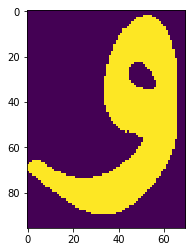

output is 21
15


In [634]:
index = random.randint(0,len(images))
display(index)

pred_output, _ = LayersForward(trainX[index], layerSize,_params)
print("output is %s" % labels[index])
#print("prediction is %s "% np.argmax(pred_output))
print(np.argmax(pred_output))

In [297]:
def display(index,Type="train"):
    if Type=="train":
        plt.imshow(images[index])
        
    elif Type=="test":
        plt.imshow(test_images[index])
        
    plt.show()

In [565]:
label_index = 16
# create the target output values (all 0.01, except the desired label which is 0.99)
targets = np.zeros(output_nodes) + 0.01
# the target label for this record
target_class = trainY[label_index]    
# feedforward propagation
pred_output, layerHistory = LayersForward(trainX[label_index], layerSize,_params)
# scale and shift the desired outputs 
targets[int(target_class)] = 0.99
# convert targets array to fit 2-dims as inputs array
targets = np.array(targets, ndmin=2).T
# Compute Cost  
cost = calculateCost(pred_output, targets)

# Backward propagation
grads = layersBackward(pred_output, targets, layerHistory, layerSize)
_params["w1"] = _params["w1"] - learning_rate * grads["dW1"]
_params["w2"] = _params["w2"] - learning_rate * grads["dW2"]

# Update Parameters
#_params = update_params(_params, grads, learning_rate)
print(_params["w1"] - learning_rate * grads["dW1"])
print("------------------")

print(learning_rate * grads["dW1"])

[[-0.00310538  0.0155775   0.00762999 ...  0.00438808  0.00860514
   0.02200462]
 [ 0.00630438  0.00617866 -0.00016964 ...  0.00192349 -0.01187966
   0.00608105]
 [-0.0082392  -0.00194852  0.02226273 ...  0.02287512  0.0110066
  -0.01881978]
 ...
 [ 0.00066697 -0.00253571  0.02227658 ...  0.00547681 -0.00911749
  -0.01323409]
 [ 0.00604876 -0.0036583   0.00642777 ... -0.00245468 -0.01035525
   0.021904  ]
 [-0.01025817  0.00189085  0.01729331 ...  0.02460277  0.01481567
   0.00169509]]
------------------
[[-5.25099399e-10  1.41284700e-10  1.01203615e-09 ... -1.26405826e-09
  -7.30020740e-10  1.72524416e-10]
 [-1.89981736e-10  5.11170125e-11  3.66156171e-10 ... -4.57338140e-10
  -2.64122579e-10  6.24195878e-11]
 [ 1.41109579e-11 -3.79673346e-12 -2.71963739e-11 ...  3.39689456e-11
   1.96177942e-11 -4.63623608e-12]
 ...
 [ 2.76117784e-11 -7.42930163e-12 -5.32168157e-11 ...  6.64691229e-11
   3.83873433e-11 -9.07200798e-12]
 [-8.04564761e-11  2.16478425e-11  1.55065617e-10 ... -1.93680803